In [5]:
%matplotlib inline
import os
import h5py
import numpy as np
from matplotlib import pyplot as plt

from mintpy.objects import timeseries
from mintpy.utils import readfile, writefile, ptime, plot as pp, utils as ut
from mintpy import view

from unwrap_error import tec

work_dir = '/Users/yunjunz/data/ChileSenAT149/mintpyOffset'
os.chdir(work_dir)
print('Go to directory', work_dir)

tec_dir = os.path.expanduser('~/data/atmosphere/TEC')

figsize = [12,4]

Go to directory /Users/yunjunz/data/ChileSenAT149/mintpyOffset


In [2]:
# HDF5 files
ts_file = os.path.join(work_dir, 'timeseriesRg.h5')
geom_file = os.path.join(work_dir, 'inputs/geometryRadar.h5')
mask_file = os.path.join(work_dir, 'maskTempCoh.h5')

# basic info
ts_obj = timeseries(ts_file)
ts_obj.open()
num_pixel = ts_obj.length * ts_obj.width
center_idx = int(ts_obj.width * (ts_obj.length / 2) + ts_obj.width / 2)
mask = readfile.read(mask_file)[0]

# offset time-series
ts_off = readfile.read(ts_file)[0]
ts_off = ts_off.reshape(ts_obj.numDate, -1)     # flatten
ts_off -= ts_off[0,:]                           # reference to the first date
ts_off[:, mask.flatten()==0] = np.nan           # mask invalid pixels
## calculate median and mean
ts_off_med = np.nanmedian(ts_off, axis=-1)
ts_off_avg = np.nanmean(ts_off, axis=-1)

open timeseries file: timeseriesRg.h5


### Ionospheric delay

LOS vector lat/lon in ionosphere: -18.2 / -69.1 deg
LOS vector incidence angle in ionosphere: 35.7 deg
effective ionosphere height: 450000.0 m
save figure to file /Users/yunjunz/data/ChileSenAT149/mintpyOffset/TS_iono.png


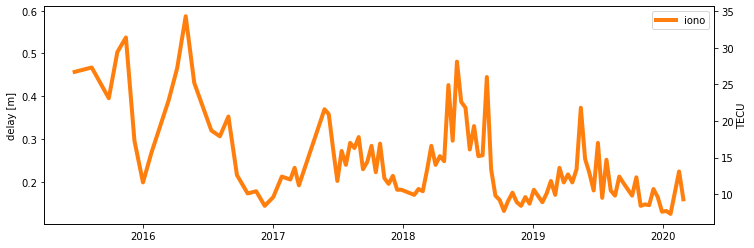

In [8]:
# 1.calculate ionospheric delay from IGS GNSS TEC
iono_file = os.path.join(work_dir, 'inputs/IgsTecJpl.h5')
if not os.path.isfile(iono_file):
    ts_obj = timeseries(ts_file)
    ts_obj.open()
    atr = ts_obj.metadata

    # download and calculation
    print('calculating the ionospheric delay from IGS GNSS TEC products...')
    ts_iono_delay = np.zeros((ts_obj.numDate, ts_obj.length, ts_obj.width), dtype=np.float32)
    ts_tecv = np.zeros(ts_obj.numDate, dtype=np.float32)
    prog_bar = ptime.progressBar(maxValue=ts_obj.numDate)
    for i in range(ts_obj.numDate):
        date_str = ts_obj.dateList[i]
        (rg_delay, 
         tecv,
         iono_lat,
         iono_lon, 
         iono_height,
         iono_inc_angle) = tec.get_iono_range_delay(tec_dir, date_str, geom_file, print_msg=False)
        ts_iono_delay[i,:,:] = rg_delay
        ts_tecv[i] = tecv
        prog_bar.update(i+1, suffix=date_str)
    prog_bar.close()

    # write to file
    atr['UNIT'] = 'm'
    atr['IONO_LAT'] = iono_lat
    atr['IONO_LON'] = iono_lon
    atr['IONO_HEIGHT'] = iono_height
    atr['IONO_INCIDENCE_ANGLE'] = np.nanmean(iono_inc_angle)
    dsDict = {}
    dsDict['timeseries'] = ts_iono_delay
    dsDict['zenithTEC'] = ts_tecv
    writefile.write(dsDict, out_file=iono_file, metadata=atr, ref_file=ts_file)

# 2. read data
atr = readfile.read_attribute(iono_file)
print('LOS vector lat/lon in ionosphere: {:.1f} / {:.1f} deg'.format(float(atr['IONO_LAT']), float(atr['IONO_LON'])))
print('LOS vector incidence angle in ionosphere: {:.1f} deg'.format(float(atr['IONO_INCIDENCE_ANGLE'])))
print('effective ionosphere height: {} m'.format(float(atr['IONO_HEIGHT'])))
with h5py.File(iono_file, 'r') as f:
    ts_iono = f['timeseries'][:].reshape(ts_obj.numDate, -1)
    ts_tecv = f['zenithTEC'][:]

# 3. plot median / mean / center
# calculate median and mean
ts_iono_avg = np.nanmean(ts_iono, axis=-1)
ts_iono_cen = ts_iono[:, center_idx]
ts_iono_med = np.nanmedian(ts_iono, axis=-1)

# plot
fig, ax = plt.subplots(figsize=figsize)
ax.plot(ts_obj.times, ts_iono_med, linewidth=4, color=pp.mplColors[1], label='iono')
ax.set_ylabel('delay [m]')
plt.legend()

ax2 = ax.twinx()
ax2.plot(ts_obj.times, ts_tecv,    linewidth=4, color=pp.mplColors[0], alpha=0)
ax2.set_ylabel('TECU')

#ax.set_xlim(left=ts_obj.times[-30])

# output
out_fig = os.path.abspath('TS_iono.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### Get tropospheric delay

save figure to file /Users/yunjunz/data/ChileSenAT149/mintpyOffset/TS_tropo.png


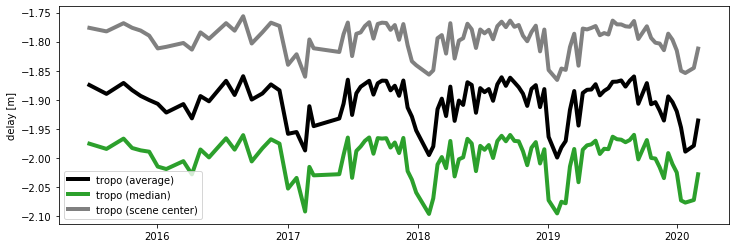

save figure to file /Users/yunjunz/data/ChileSenAT149/mintpyOffset/TS_tropo_diff.png


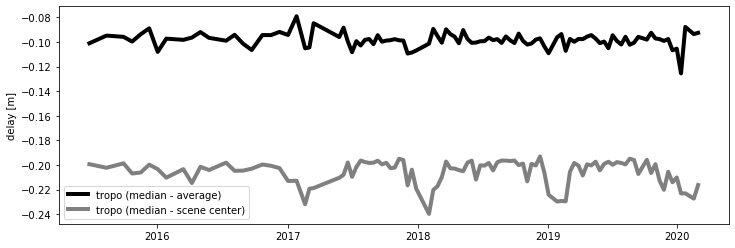

In [60]:
tropo_file = os.path.join(work_dir, 'inputs/ERA5.h5')

# 1. calculate absolute tropospheric delay from ERA5
if not os.path.isfile(tropo_file):
    !tropo_pyaps3.py -f timeseriesRg.h5 -g inputs/geometryRadar.h5

# 2. read data
ts_tropo = readfile.read(tropo_file)[0].reshape(ts_obj.numDate, -1)

# 3. plot median / mean / center
# calculate median and mean
ts_tropo_avg = np.nanmean(ts_tropo, axis=-1)
ts_tropo_med = np.nanmedian(ts_tropo, axis=-1)
ts_tropo_cen = ts_tropo[:, center_idx]

# plot
fig, ax = plt.subplots(figsize=figsize)
ax.plot(ts_obj.times, ts_tropo_avg, linewidth=4, color='k',             label='tropo (average)')
ax.plot(ts_obj.times, ts_tropo_med, linewidth=4, color=pp.mplColors[2], label='tropo (median)')
ax.plot(ts_obj.times, ts_tropo_cen, linewidth=4, color='gray',          label='tropo (scene center)')
ax.set_ylabel('delay [m]')
#ax.set_xlim(left=ts_obj.times[-30])
plt.legend()

# output
out_fig = os.path.abspath('TS_tropo.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

# 4. plot median / mean / center difference
fig, ax = plt.subplots(figsize=figsize)
ax.plot(ts_obj.times, ts_tropo_med - ts_tropo_avg, linewidth=4, color='k', label='tropo (median - average)')
ax.plot(ts_obj.times, ts_tropo_med - ts_tropo_cen, linewidth=4, color='gray', label='tropo (median - scene center)')
ax.set_ylabel('delay [m]')
#ax.set_xlim(left=ts_obj.times[-30])
plt.legend()

# output
out_fig = os.path.abspath('TS_tropo_diff.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### Compare time-series between range offset, ionospheric delay and tropospheric delay

In [62]:
# calculate the relative range delay
ts_iono_med -= ts_iono_med[0]
ts_iono_med *= -1
ts_tropo_med -= ts_tropo_med[0]
ts_atmos = ts_iono_med + ts_tropo_med

save figure to file /Users/yunjunz/data/ChileSenAT149/mintpyOffset/TS_rgOff_iono_tropo.png


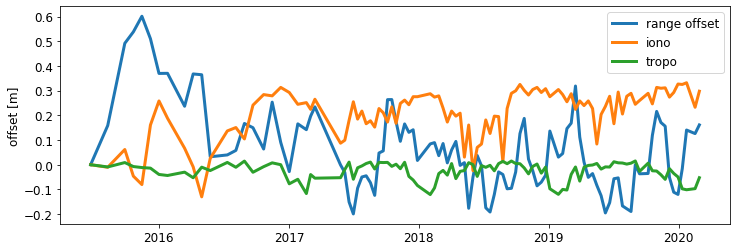

In [64]:
## plot
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=figsize)
ax.plot(ts_obj.times, ts_off_med,   linewidth=3, label='range offset')
ax.plot(ts_obj.times, ts_iono_med,  linewidth=3, label='iono')
ax.plot(ts_obj.times, ts_tropo_med, linewidth=3, label='tropo')
ax.set_ylabel('offset [m]')
#ax.set_xlim(left=ts_obj.times[-30])
plt.legend()

# output
out_fig = os.path.abspath('TS_rgOff_iono_tropo.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

save figure to file /Users/yunjunz/data/ChileSenAT149/mintpyOffset/seqTS_rgOff_iono_tropo.png


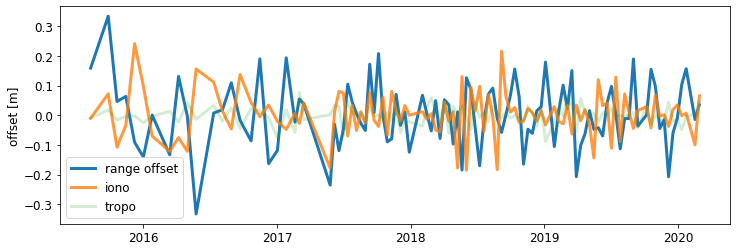

In [65]:
## plot
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=figsize)
ax.plot(ts_obj.times[1:], np.diff(ts_off_med),   linewidth=3, alpha=1, label='range offset')
ax.plot(ts_obj.times[1:], np.diff(ts_iono_med),  linewidth=3, alpha=0.8, label='iono')
ax.plot(ts_obj.times[1:], np.diff(ts_tropo_med), linewidth=3, alpha=0.2, label='tropo')
ax.set_ylabel('offset [m]')
#ax.set_xlim(left=ts_obj.times[-30])
plt.legend()

# output
out_fig = os.path.abspath('seqTS_rgOff_iono_tropo.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

save figure to file /Users/yunjunz/data/ChileSenAT149/mintpyOffset/TS_rgOff_atmos.png


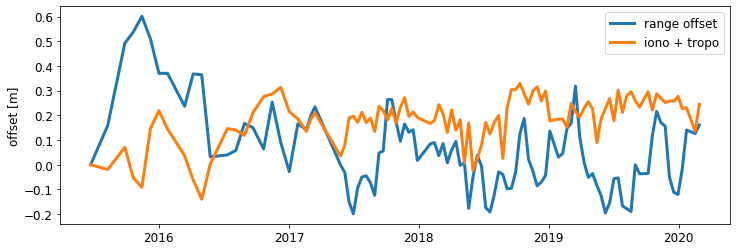

In [68]:
## plot
fig, ax = plt.subplots(figsize=figsize)
ax.plot(ts_obj.times, ts_off_med, linewidth=3, label='range offset')
ax.plot(ts_obj.times, ts_atmos,   linewidth=3, label='iono + tropo')
ax.set_ylabel('offset [m]')
#ax.set_xlim(left=ts_obj.times[-30])
plt.legend()

# output
out_fig = os.path.abspath('TS_rgOff_atmos.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

save figure to file /Users/yunjunz/data/ChileSenAT149/mintpyOffset/seqTS_rgOff_atmos.png


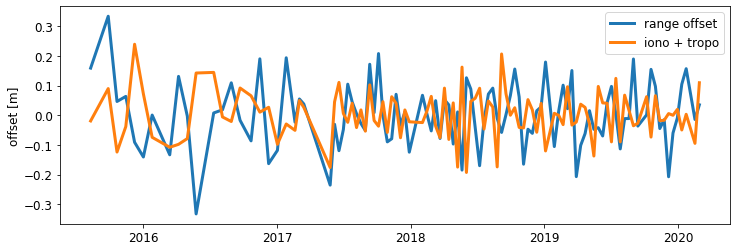

In [67]:
## plot
fig, ax = plt.subplots(figsize=figsize)
ax.plot(ts_obj.times[1:], np.diff(ts_off_med), linewidth=3, label='range offset')
ax.plot(ts_obj.times[1:], np.diff(ts_atmos),   linewidth=3, label='iono + tropo')
ax.set_ylabel('offset [m]')
#ax.set_xlim(left=ts_obj.times[-30])
plt.legend()

# output
out_fig = os.path.abspath('seqTS_rgOff_atmos.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()